In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision as tv
from torch.utils.data import DataLoader
import clip
from tokenizers import Tokenizer
from PIL import Image
import argparse
import copy
from models import caption
from datasets import utils
import models
from configuration import Config
import os
import tqdm
from PIL import Image
import numpy as np
import random
from datasets.utils import nested_tensor_from_tensor_list, read_json
import json 
from cider import cider_score
import cv2
import matplotlib.pyplot as plt
from scipy import spatial
import language_evaluation

/root/anaconda3/envs/hw3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_DIM = 299
#configuration
config = Config()

## Model

In [3]:
checkpoint_path = './checkpoint_1120.pth'

print("Found checkpoint! Loading!")
model,_ = caption.build_model(config)
print("Loading Checkpoint...")
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])

Found checkpoint! Loading!


/root/anaconda3/envs/hw3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/hw3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading Checkpoint...


<All keys matched successfully>

## Data

In [7]:
'''
About Data
'''
def under_max(image):
    if image.mode != 'RGB':
        image = image.convert("RGB")

    shape = np.array(image.size, dtype=np.float64)
    long_dim = max(shape)
    scale = MAX_DIM / long_dim

    new_shape = (shape * scale).astype(int)
    image = image.resize(new_shape)

    return image


transform = tv.transforms.Compose([
    tv.transforms.Resize((MAX_DIM, MAX_DIM)),
    #tv.transforms.Lambda(under_max),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class HW3_2_eval(Dataset):
    def __init__(self, path, transform=transform):
        super().__init__()

        self.files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('3646190566.jpg') or file.endswith('000000539189.jpg')]
        self.transform = transform
        
    def __filename__(self, idx):
        file_name = self.files[idx].split('.')[0]
        return file_name
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):        
        #print(image_id, caption)
        image = Image.open(self.files[idx])
        if self.transform:
            image = self.transform(image)
        image = nested_tensor_from_tensor_list(image.unsqueeze(0))
       
        return image.tensors.squeeze(0), image.mask.squeeze(0)

In [5]:
def create_caption_and_mask(start_token, max_length, pred_len):
    caption_template = torch.zeros((pred_len, max_length), dtype=torch.long)
    mask_template = torch.ones((pred_len, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

# Evaluate

In [8]:
#registor hook for layers
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output[1].detach()
    return hook

@torch.no_grad()
def evaluate(model, data_loader, device):
    #set seed
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    
    #tokenizer
    tokenizer = Tokenizer.from_pretrained("bert-base-uncased")
    start_token = tokenizer.token_to_id("[SEP]")
    end_token = tokenizer.token_to_id("[CLS]")
    #print(dir(tokenizer))
    
    #model evaluation
    model.to(device)
    #model.eval()
    total = len(data_loader)
    
    
    with tqdm.tqdm(total=total) as pbar:
        pred_list = []
        atten_maps = []
        for images, masks in data_loader:
            #images: (1, 3, 299, 299), masks: (1, 299, 299), cap: (1 ,129) 
            
            pred_len = images.shape[0] #[32, 32, ....29] 
            caps, cap_masks = create_caption_and_mask(start_token, config.max_position_embeddings, pred_len)
            
            images = images.to(device)
            caps = caps.to(device)
            cap_masks = cap_masks.to(device)
            pbar.update(1)
            
            temp = []
            for i in range(config.max_position_embeddings-1):
                #text predictions
                #predicts = predictions[:,i,:]
                model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(get_features('att'))
                outputs = model(images[0].unsqueeze(0), caps[0].unsqueeze(0), cap_masks[0].unsqueeze(0))
                temp.append(features['att'].cpu().numpy())
            
                #outputs = model(images[0].unsqueeze(0), caps[0].unsqueeze(0), cap_masks[0].unsqueeze(0))
                #cross_weights = model.transformer.decoder.layers[-1](images[0].unsqueeze(0), caps[0].unsqueeze(0), cap_masks[0].unsqueeze(0))
                predictions = copy.deepcopy(outputs)
                predicts = predictions[0,i,:] #b
                predicted_id = torch.argmax(predicts, axis=-1) #(1)
                #temp.append(cross_weights)
                
                if predicted_id.item() == 102:
                    atten_maps.append(temp)
                    #print(atten_maps)
                    break

                caps[0, i+1] = predicted_id.item() #predicted_id[0] 
                cap_masks[0, i+1] = False

            #decode a sentence
            result_pred = tokenizer.decode(caps[0].tolist(), skip_special_tokens=True).capitalize()
            pred_list.append(result_pred)
            
        #print cider score
        print('length predictions:', len(pred_list))
    
    return  pred_list, atten_maps

## Run evaluate for 5 images

In [9]:
device = torch.device(config.device)
print(f'Initializing Device: {device}')

data_path = '../hw3_data/p2_data/images/val/'
dataset_test = HW3_2_eval(data_path, transform=transform)

print(f"Test: {len(dataset_test)}")

#data
sampler_test = torch.utils.data.SequentialSampler(dataset_test)
data_loader_test = DataLoader(dataset_test, batch_size=1, sampler=sampler_test, drop_last=False, num_workers=config.num_workers)
pred_list, attns = evaluate(model, data_loader_test, device)

Initializing Device: cuda
Test: 2


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]

length predictions: 2


In [10]:
pred_list

['A man in a blue shirt and a hat is holding a gun while a woman is standing on a boat.',
 'A young boy sitting on a couch playing a video game.']

In [11]:
a = '<BOS> '+pred_list[0]+' <EOS>'
a.split()

['<BOS>',
 'A',
 'man',
 'in',
 'a',
 'blue',
 'shirt',
 'and',
 'a',
 'hat',
 'is',
 'holding',
 'a',
 'gun',
 'while',
 'a',
 'woman',
 'is',
 'standing',
 'on',
 'a',
 'boat.',
 '<EOS>']

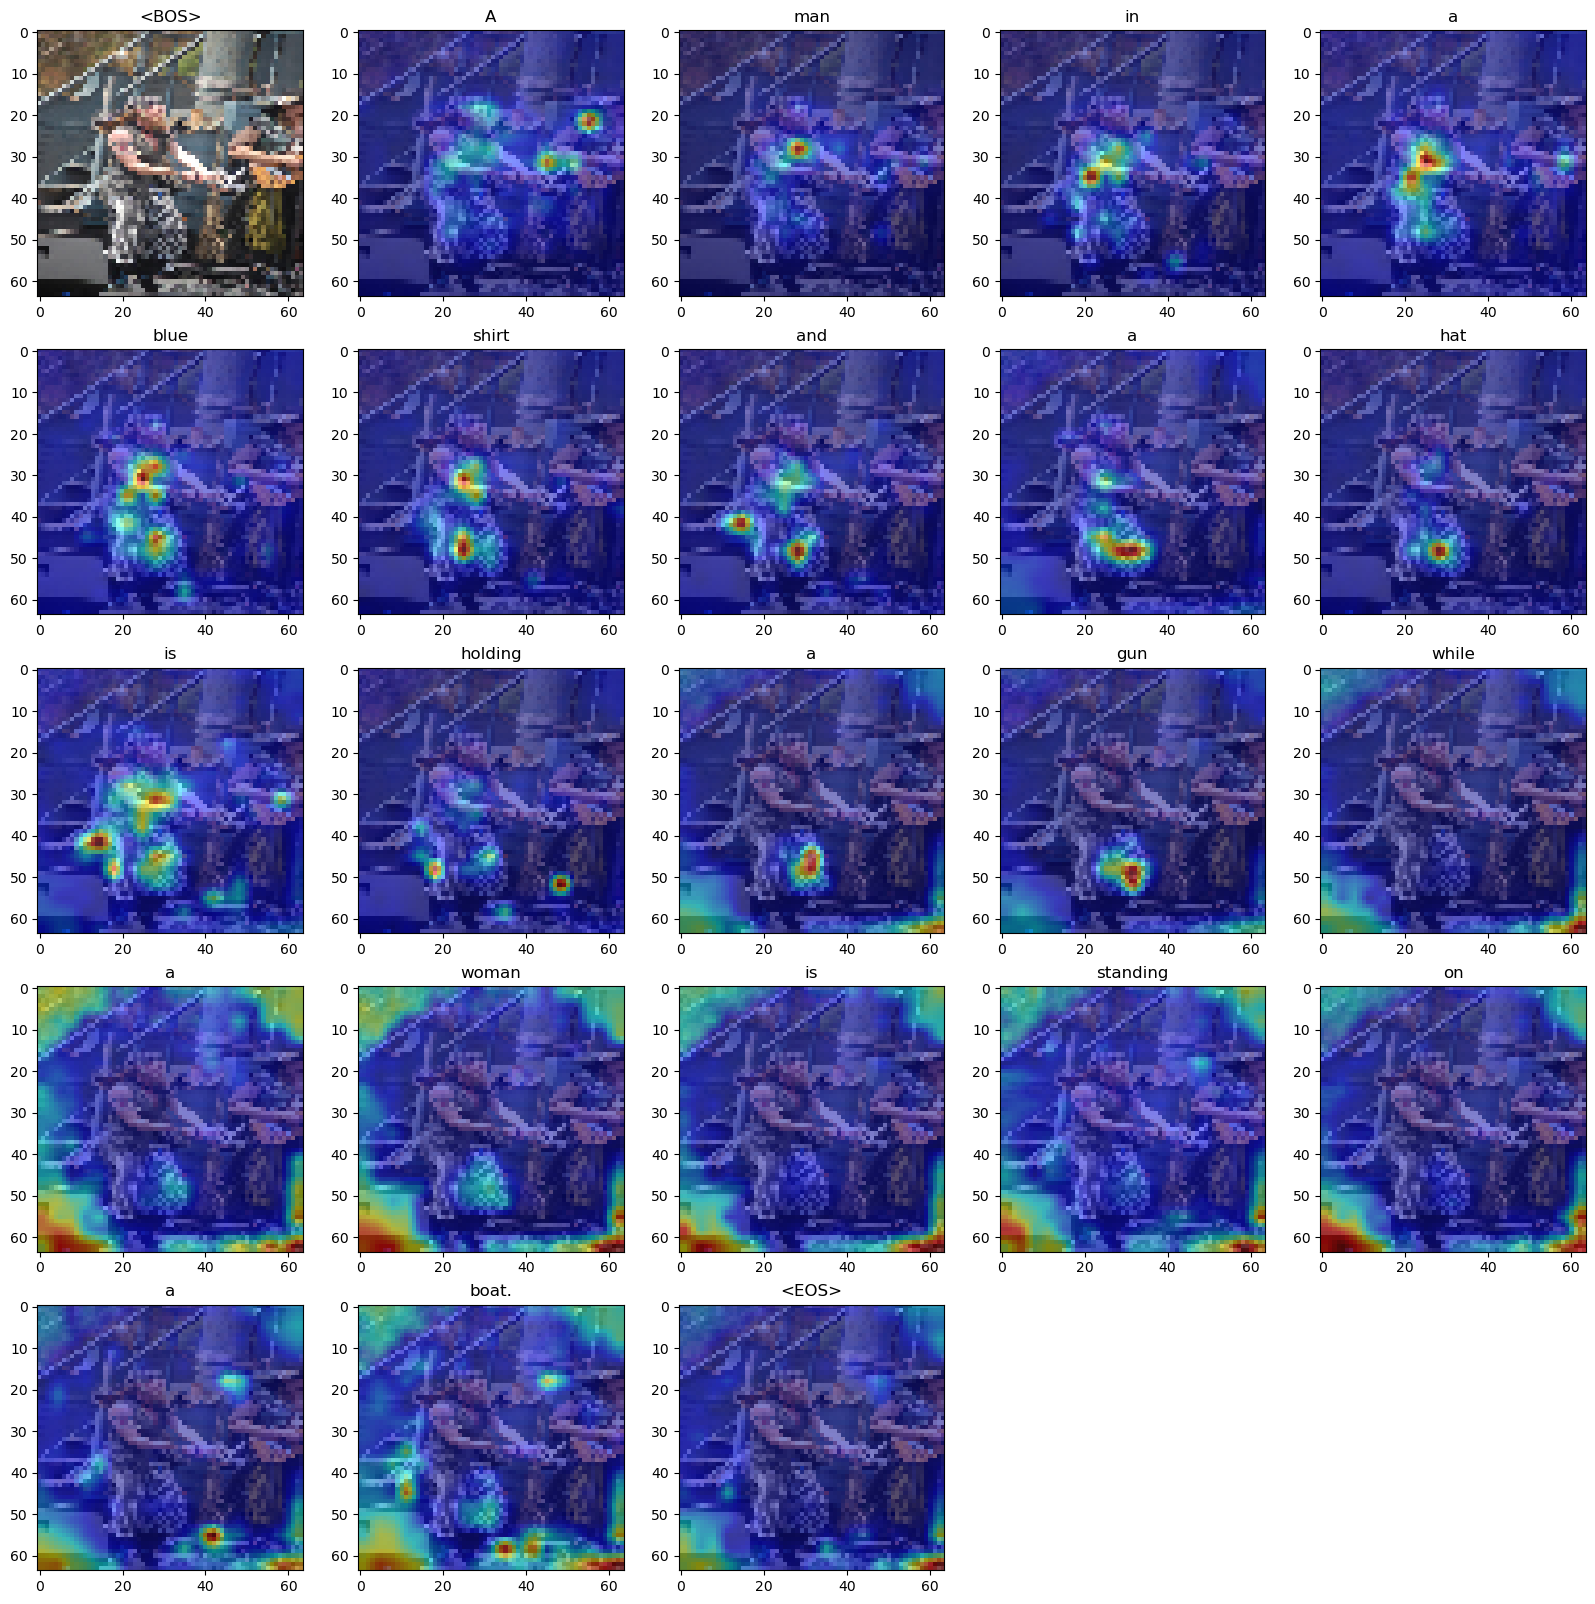

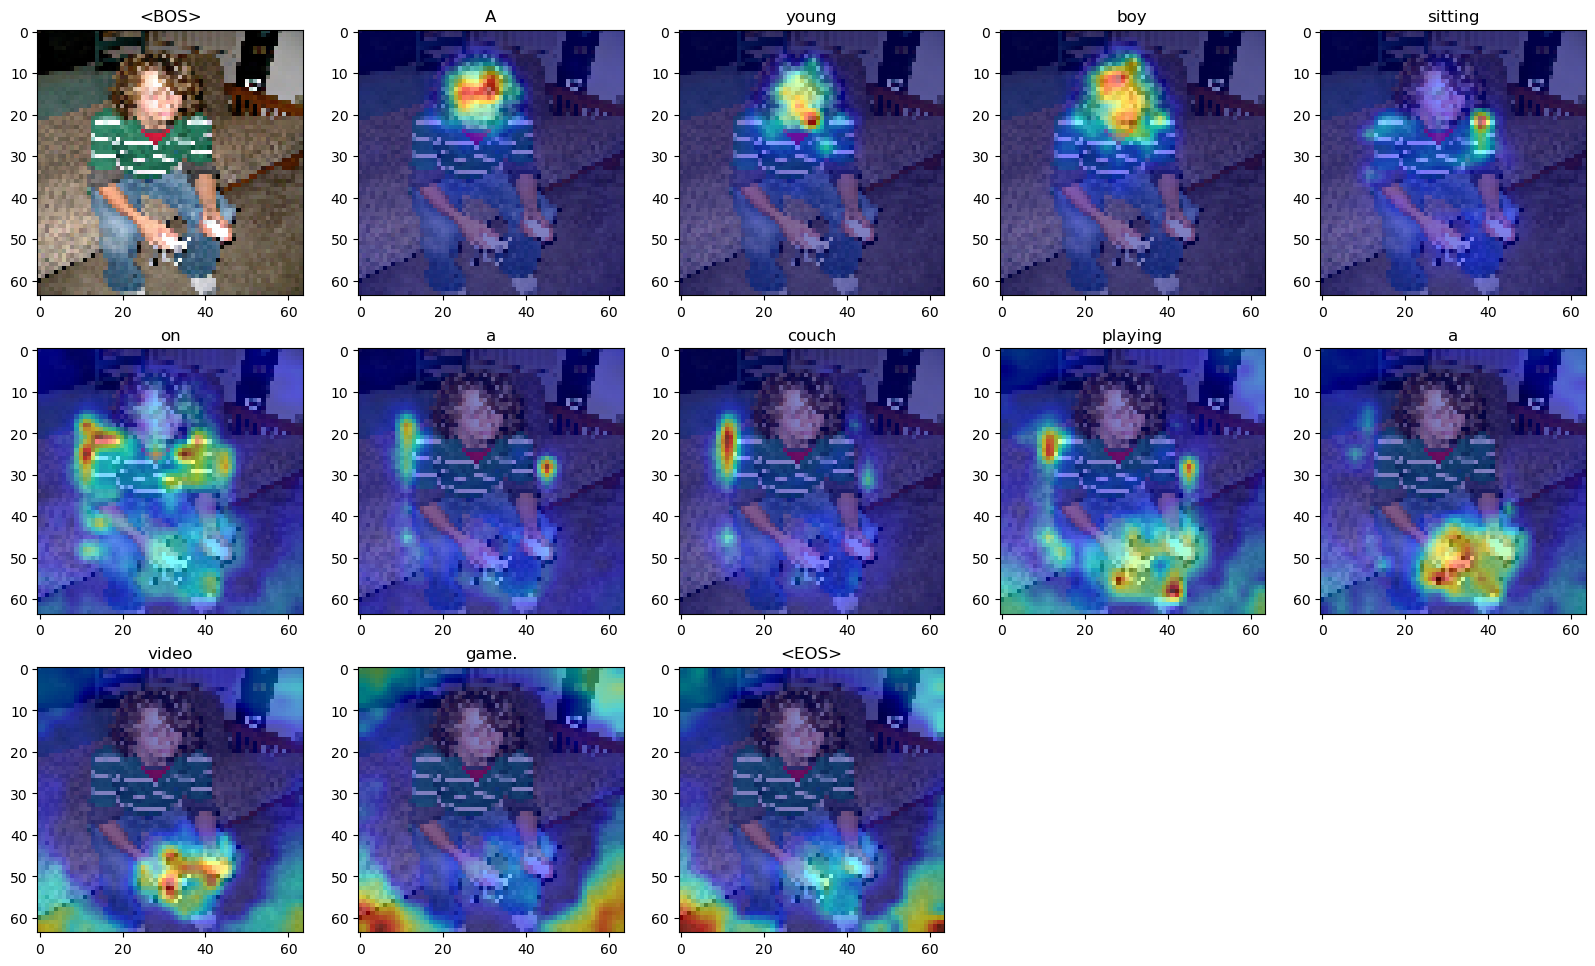

In [15]:
#imgs_full = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith('jpg')]

imgs_full = [data_path+'3646190566.jpg', data_path+'000000539189.jpg']
#fig = plt.figure(figsize=(40,40))
for i, att in enumerate(attns): #(word_len, batch, max_length, 361)
    fig = plt.figure(figsize=(20,20))
    im = torch.from_numpy(cv2.imread(imgs_full[i])).permute(2,0,1)
    img = tv.transforms.Resize((64, 64))(im)
    img  = img.numpy().transpose(1,2,0)[:,:,::-1]
    preds = '<BOS> '+pred_list[i]+' <EOS>'
    splits = preds.split()
    num = 2
    #special case
    #if i == 1:
    #    att = att[:-1]
    for w, word in enumerate(att[:-1]): #(1, 128, 361)
        ax = plt.subplot(5,5, num)
        #word attn processing
        word = word.transpose(1,0,2)
        word = torch.from_numpy(word[w]).reshape((19, 19)).unsqueeze(0)
        
        #attn_map = tv.transforms.Resize((64, 64))(word) #+ torch.eye(64)
        attn_map = torch.from_numpy(np.vstack([word, word, word]))#.transpose(1,2,0) #conver to 3 channels
        attn_map = tv.transforms.Resize((64, 64))(attn_map)
        attn_map = attn_map / attn_map.max()
        attn_map = (attn_map * 255).numpy().transpose(1,2,0).astype('uint8')
        
        
        # scale the image
        heatmap_img = cv2.applyColorMap(attn_map, cv2.COLORMAP_JET)[:,:,::-1]
        super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
        
        
        if w == 0:
            bx = plt.subplot(5,5,1)
            bx.imshow(img)
            bx.set_title(splits[0])
            ax.imshow(super_imposed_img)
            ax.set_title(splits[1])
        else:
            ax.imshow(super_imposed_img)
            ax.set_title(splits[w+1])
        num += 1
    plt.savefig(f'./plots/visval_{i+1}')
    plt.show()

## Read annotaion, predict json file

In [4]:
import json
with open('./pred_1120.json') as json_file:
    pred = json.load(json_file)
    
with open('../hw3_data/p2_data/val.json') as val_file:
    truth = json.load(val_file)

In [5]:
pred

{'5769934076': 'A man is preparing food at a restaurant.',
 '000000304355': 'A bathroom with a toilet and a sink',
 '3191169746': 'A man in a cowboy hat is walking through a forest.',
 '000000295642': 'A train is approaching a train station with people walking.',
 '000000336937': 'A row of toilets in a row of white toilets.',
 '000000122597': 'A group of teddy bears sitting on top of a window.',
 '000000182416': 'A woman sitting on a sidewalk talking on a cell phone.',
 '000000480313': 'A man holding a hot dog in his hand.',
 '229059021': 'A man and a man laying on a bench.',
 '3677954655': 'A man in a helmet and a helmet is jumping up on a pole.',
 '4725077313': 'A man sitting at a table with a book',
 '000000543042': "A black and white photograph of a child ' s toy.",
 '2444070322': 'A woman in a blue shirt holding a bottle of coffee.',
 '000000257301': 'A man and a woman walking a dog on a path.',
 '4854738791': 'A man and woman are standing on a rock.',
 '000000312282': 'A plate of

In [6]:
class HW3_2_eval(Dataset):
    def __init__(self, ann):
        super().__init__()
        self.annot = [(val['image_id'], val['caption']) for val in ann['annotations']]
        
        #file dict: id2filename
        self.file_dict = {}
        for file in ann['images']:
            self.file_dict[file['id']] = file['file_name'] 
    
    def __len__(self):
        return len(self.annot)

    def __getitem__(self, idx):        
        image_id, caption = self.annot[idx]
        filename = self.file_dict[image_id].split('.')[0]
        return filename, caption

## annotation dictionary

In [7]:
ann = HW3_2_eval(truth)
ann_dict = {}
for i in range(len(ann)):
    if ann[i][0] not in ann_dict:
        ann_dict[ann[i][0]] = [ann[i][1]]
    ann_dict[ann[i][0]] = ann_dict[ann[i][0]] + [ann[i][1]]

## stored sorted results

In [8]:
sort_caps = []
sort_preds = []
for keys, values in pred.items():
    caps = ann_dict[keys]
    sort_caps.append(caps)
    sort_preds.append(values)

## compute cider

In [7]:
evaluator = language_evaluation.CocoEvaluator()
results = evaluator.run_evaluation(sort_preds, sort_caps)
cider = results['CIDEr']
print('cider:', cider)

PTBTokenizer tokenized 134385 tokens at 1035945.30 tokens per second.
PTBTokenizer tokenized 21996 tokens at 317317.65 tokens per second.
Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... don

SPICE evaluation took: 2.044 min
cider: 1.0377260991286377


## Clip score

In [9]:
def get_clipscore(img_embed, text_embed):
    w = 2.5
    cos_sim = 1 - spatial.distance.cosine(img_embed, text_embed)
    return w*max(cos_sim, 0)

In [19]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

#data path
val_path = '../hw3_data/p2_data/images/val/'
path_list = [os.path.join(val_path,x) for x in os.listdir(val_path) if x.endswith(".jpg")]
tokenizer = Tokenizer.from_pretrained("bert-base-uncased")

im_feat_full = []
txt_feat_full = []
clip_tot = {}
for i, path in enumerate(path_list):
    image = Image.open(path)
    filename = path.split('/')[-1].split('.')[0]
    caption = pred[filename]
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize(caption).to(device)
    
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input) #(1,512)
        text_features = model.encode_text(text_input)
        clipscore = get_clipscore(image_features.cpu().numpy().reshape(-1), text_features.cpu().numpy().reshape(-1))
        clip_tot[filename] = clipscore

"\nim_embed = np.hstack(im_feat_full)\ntxt_embed = np.hstack(txt_feat_full)\nclipscore = get_clipscore(im_embed, txt_embed)\nprint('clipscore:', clipscore)\n"

In [26]:
sort_dict = dict(sorted(clip_tot.items(), key=lambda item: item[1]))

for _, items in enumerate(sort_dict.items()):
    print(items)

('3646190566', 0.3289794921875)
('2444664718', 0.34423828125)
('461413605', 0.36468505859375)
('3690431163', 0.37933349609375)
('4927180699', 0.38970947265625)
('10637120', 0.3912353515625)
('000000517430', 0.40863037109375)
('000000516233', 0.4205322265625)
('7185451077', 0.43182373046875)
('1516097777', 0.43212890625)
('3088677667', 0.43609619140625)
('000000229149', 0.4449462890625)
('8036608675', 0.44708251953125)
('000000408363', 0.45257568359375)
('4891182729', 0.4681396484375)
('4859528111', 0.46966552734375)
('4505012194', 0.4705810546875)
('000000127926', 0.4730224609375)
('000000302489', 0.477294921875)
('5518766647', 0.4791259765625)
('243952171', 0.4815673828125)
('000000001999', 0.4833984375)
('6838087446', 0.484619140625)
('000000201220', 0.4876708984375)
('6536482681', 0.48919677734375)
('491987177', 0.48980712890625)
('000000568308', 0.48980712890625)
('4898860007', 0.49224853515625)
('2127566743', 0.4937744140625)
('4366908113', 0.49530029296875)
('000000196379', 0.495